<h1 style="color:green">Deep Learning Classification</h1>

<h3 style="color:yellow">Libraries</h3>

In [1]:
# EDA
import matplotlib.pyplot as plt
import seaborn as sns

# DATASET
import pandas as pd
import os

# IMAGES
from PIL import Image
import cv2 
import numpy as np 

# DEEP LEARNING
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils import class_weight

2024-10-08 12:34:57.472245: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 12:34:57.531958: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-08 12:34:57.547391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-08 12:34:57.643531: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-08 12:34:58.709973: W tensorflow/compiler/tf2

<h3 style="color:yellow">Data Visualization</h3>

In [2]:
dataset = pd.read_csv('images.csv')
dataset.head()

,image_name,label
0,1.jpg,INJURED
1,2.jpg,NOT INJURED
2,3.jpg,NOT INJURED
3,4.jpg,NOT INJURED
4,5.jpg,NOT INJURED


In [3]:
# convert image to array
def convert_image_to_array(image_folder_path, image_names, target_list):
    for image_name in image_names:
        image_path = os.path.join(image_folder_path, image_name)
        try:
            with Image.open(image_path) as img:
                img_array = np.array(img)
                target_list.append(img_array)
        except FileNotFoundError:
            print(f"File not found: {image_name}")

In [4]:
# make list of images arrays
images = []
convert_image_to_array("./images/", dataset['image_name'], images)

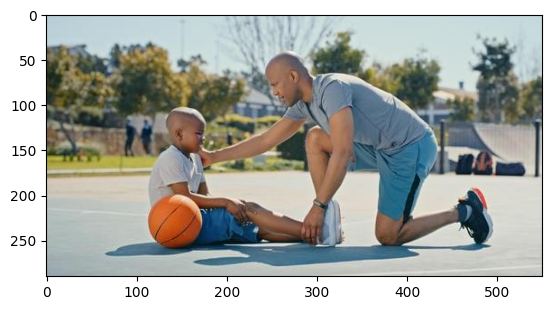

In [5]:
# show an image
plt.figure()
plt.imshow(images[0])
plt.show()

In [6]:
# dataset with keypoints and labels
data = pd.read_csv('pose_keypoints_and_labels.csv')
data

,image_name,keypoint_1_x,keypoint_1_y,keypoint_2_x,keypoint_2_y,keypoint_3_x,keypoint_3_y,keypoint_4_x,keypoint_4_y,keypoint_5_x,...,keypoint_29_y,keypoint_30_x,keypoint_30_y,keypoint_31_x,keypoint_31_y,keypoint_32_x,keypoint_32_y,keypoint_33_x,keypoint_33_y,label
0,1.jpg,0.464063,0.302966,0.467148,0.267607,0.472185,0.262088,0.477513,0.255661,0.458180,...,0.813437,0.860561,0.693109,0.384857,0.853860,0.879906,0.851668,0.332129,0.789891,INJURED
1,2.jpg,0.509636,0.287818,0.518921,0.239143,0.526355,0.233971,0.534081,0.228827,0.505776,...,1.567118,0.783957,1.620279,0.643393,1.614389,0.719477,1.666707,0.622712,1.676396,NOT INJURED
2,3.jpg,0.510626,0.216307,0.526216,0.185609,0.534463,0.186989,0.543566,0.188615,0.495537,...,1.552322,0.599623,1.599746,0.455406,1.601019,0.570232,1.663622,0.468519,1.659812,NOT INJURED
3,4.jpg,0.571510,0.363144,0.591165,0.307612,0.606205,0.308041,0.620086,0.309002,0.549530,...,2.716885,0.677303,2.817077,0.428859,2.812584,0.628669,2.896181,0.461584,2.882680,NOT INJURED
4,5.jpg,0.520769,0.504812,0.514968,0.477050,0.508437,0.476096,0.503107,0.475682,0.529123,...,1.675457,0.550453,1.674099,0.492075,1.718112,0.561834,1.707383,0.525420,1.747067,NOT INJURED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111,112.jpg,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,INJURED
112,113.jpg,0.364453,0.351558,0.373222,0.336792,0.378051,0.336610,0.382887,0.336488,0.358602,...,0.735689,0.561257,0.750517,0.501329,0.743889,0.606049,0.723485,0.540212,0.754494,INJURED
113,114.jpg,0.501674,0.279850,0.517044,0.240473,0.530180,0.234927,0.540913,0.230170,0.477002,...,1.112220,0.613205,1.115071,0.564076,1.130230,0.525241,1.222607,0.476551,1.239316,INJURED
114,115.jpg,0.431283,0.401059,0.440495,0.363574,0.482979,0.349994,0.487485,0.351424,0.391609,...,1.505756,0.497286,1.483333,0.329306,1.550803,0.472562,1.559758,0.305845,1.681458,INJURED


Image: ./images/84.jpg, Number of Keypoints: 17


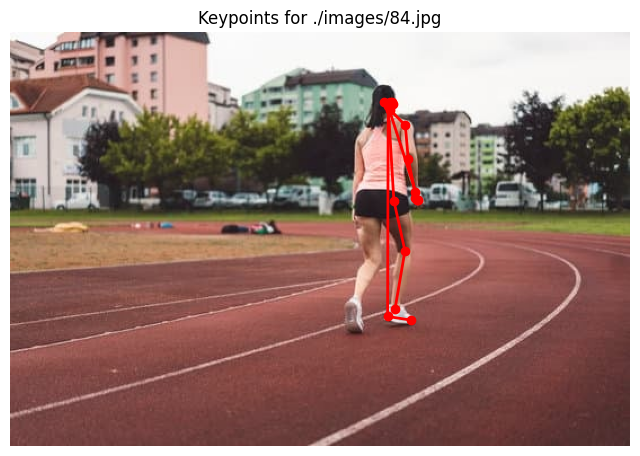

Image: ./images/5.jpg, Number of Keypoints: 17


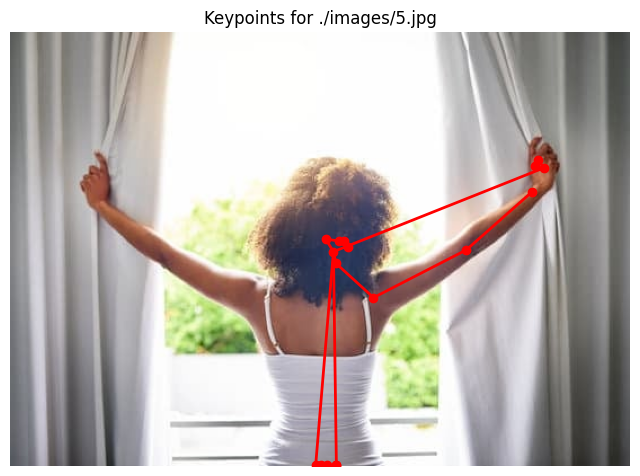

Image: ./images/43.jpg, Number of Keypoints: 17


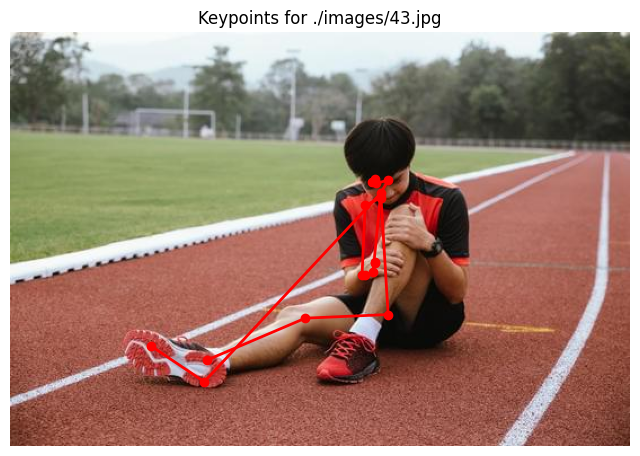

Image: ./images/41.jpg, Number of Keypoints: 17


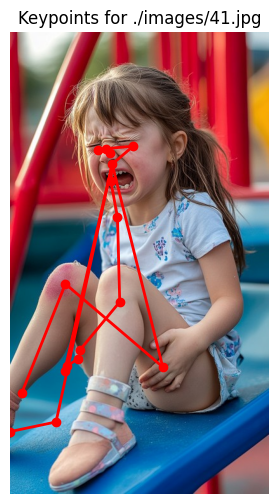

Image: ./images/11.jpg, Number of Keypoints: 17


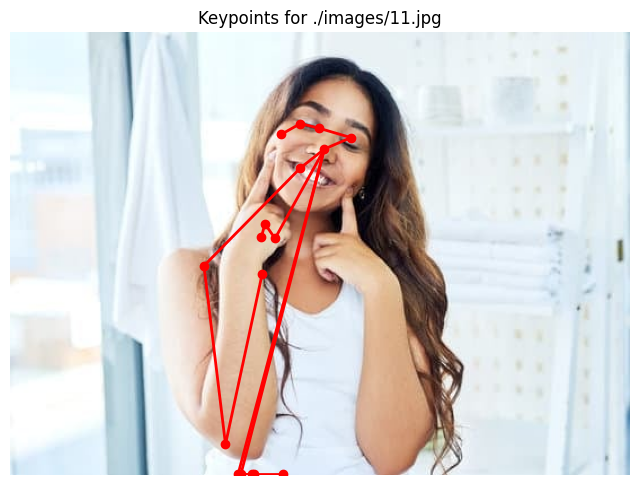

Image: ./images/48.jpg, Number of Keypoints: 17


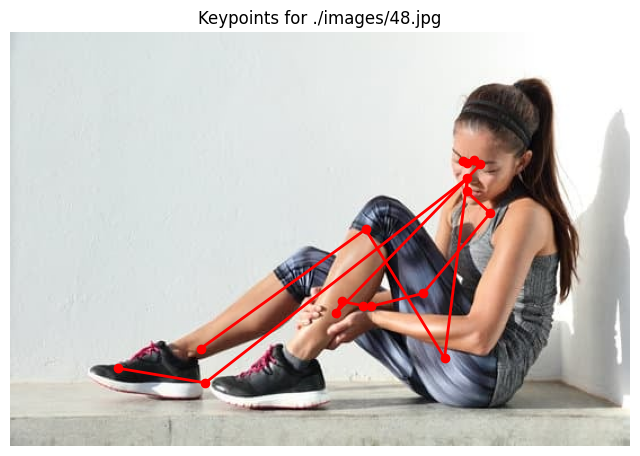

Image: ./images/111.jpg, Number of Keypoints: 17


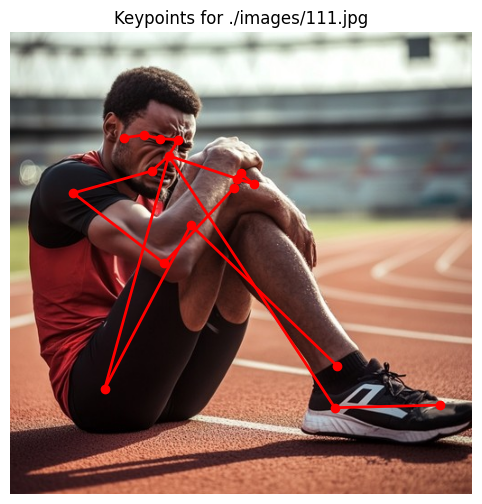

Image: ./images/37.jpg, Number of Keypoints: 17


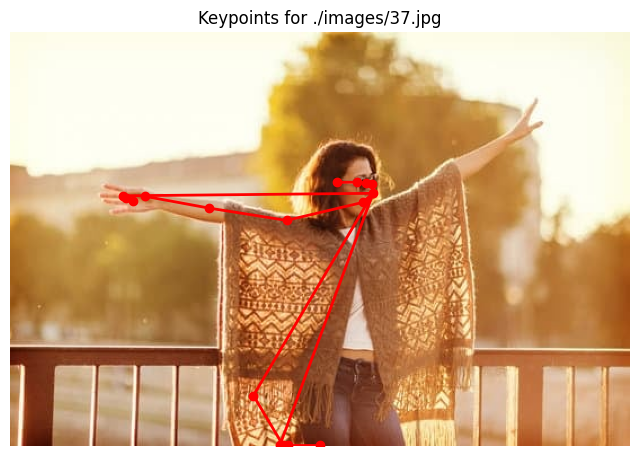

Image: ./images/71.jpg, Number of Keypoints: 17


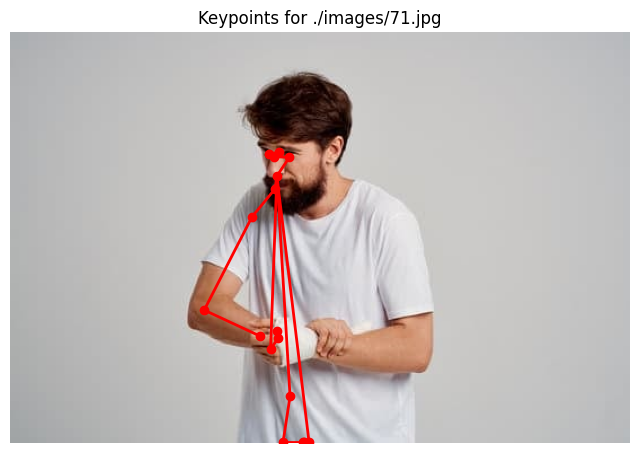

Image: ./images/12.jpg, Number of Keypoints: 17


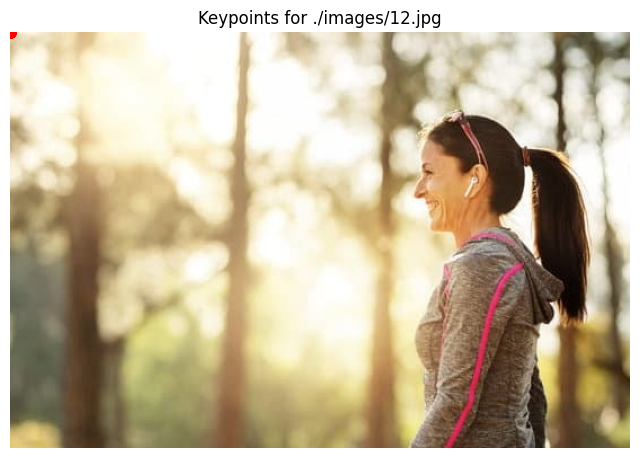

In [7]:
# visualize images with keypoints
# define connections between keypoints 
connections = [
    (1, 2), (2, 3), (3, 4), (4, 5),  # Right arm
    (1, 6), (6, 7), (7, 8), (8, 9),  # Left arm
    (1, 10), (10, 11), (11, 12),     # Neck to torso
    (1, 13), (13, 14), (14, 15),     # Right leg
    (1, 16), (16, 17), (17, 18),     # Left leg
    (10, 19), (19, 20), (20, 21)     # Backbone
]

# get 10 random images
random_images = data.sample(n=10, random_state=42)

# visualizing the images and keypoints
for index, row in random_images.iterrows():
    image_path = "./images/" + row['image_name']
    image = cv2.imread(image_path)

    keypoints_x = []
    keypoints_y = []
    for i in range(1, 35, 2):  
        keypoints_x.append(row[f'keypoint_{i}_x'])
        keypoints_y.append(row[f'keypoint_{i}_y'])

    print(f"Image: {image_path}, Number of Keypoints: {len(keypoints_x)}")

    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  

    img_height, img_width = image.shape[:2]

    # draw keypoints, clamping them within image bounds
    for (x, y) in zip(keypoints_x, keypoints_y):
        # convert relative coordinates to absolute, clamping to image bounds
        x_abs = max(0, min(x * img_width, img_width - 1))
        y_abs = max(0, min(y * img_height, img_height - 1))
        plt.plot(x_abs, y_abs, 'ro')  # draw point

    # draw lines between keypoints, ensuring we don't exceed the length of keypoints_x
    for (start, end) in connections:
        if start - 1 < len(keypoints_x) and end - 1 < len(keypoints_x):
            # get absolute coordinates and clamp them to image bounds
            start_x = max(0, min(keypoints_x[start - 1] * img_width, img_width - 1))
            start_y = max(0, min(keypoints_y[start - 1] * img_height, img_height - 1))
            end_x = max(0, min(keypoints_x[end - 1] * img_width, img_width - 1))
            end_y = max(0, min(keypoints_y[end - 1] * img_height, img_height - 1))

            # draw line between the points
            plt.plot([start_x, end_x], [start_y, end_y], 'r-', linewidth=2)

    plt.title(f'Keypoints for {image_path}')
    plt.axis('off')
    plt.show()

<h3 style="color:yellow">Exploratory Data Analysis (EDA)</h3>

/tmp/ipykernel_4681/32732447.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')


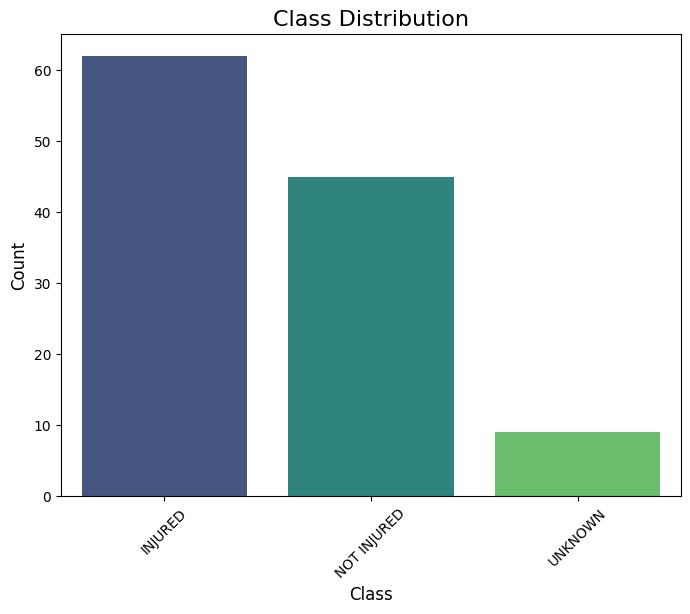

In [8]:
# class distribution graph
class_counts = data['label'].value_counts()

# plotting the distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette='viridis')
plt.title('Class Distribution', fontsize=16)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

<h3 style="color:yellow">Data Preprocessing</h3>

In [9]:
# encode categorical targets
label = LabelEncoder()
y = label.fit_transform(data['label'])
y

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 2, 0,
       2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [10]:
# standardize keypoints features
keypoint_columns = [f'keypoint_{i}_x' for i in range(1, 34)] + [f'keypoint_{i}_y' for i in range(1, 34)]
X = data[keypoint_columns].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [11]:
# split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [12]:
print(f"Length of training images with keypoints is {len(X_train)}.")
print(f"Length of testing images with keypoints is {len(X_test)}.")

Length of training images with keypoints is 81.
Length of testing images with keypoints is 35.


<h3 style="color:yellow">Model training, predicting and evaluating</h3>

In [13]:
# model creation
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],)))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dense(1024, activation='relu', kernel_regularizer=l2(0.001)))
model.add(BatchNormalization())
model.add(Dense(3, activation='softmax'))

# model compilation
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
# model summary
model.summary()

/home/marius/Desktop/Python/myenv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │         3,075 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 684,291 (2.61 MB)

 Trainable params: 680,707 (2.60 MB)

 Non-trainable params: 3,584 (14.00 KB)

In [14]:
# handle class imbalance
class_weights = class_weight.compute_class_weight('balanced', 
                                                 classes=np.unique(y_train), 
                                                 y=y_train)

In [44]:
# model training
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 15)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
history = model.fit(X_train, y_train, epochs=100, batch_size=32, 
          validation_split=0.3, 
          class_weight=dict(enumerate(class_weights)),
          callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.9554 - loss: 1.2111 - val_accuracy: 0.5200 - val_loss: 2.5548 - learning_rate: 1.9531e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9777 - loss: 1.1578 - val_accuracy: 0.5200 - val_loss: 2.5693 - learning_rate: 1.9531e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9315 - loss: 1.2373 - val_accuracy: 0.5200 - val_loss: 2.5829 - learning_rate: 1.9531e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9554 - loss: 1.1840 - val_accuracy: 0.5200 - val_loss: 2.5996 - learning_rate: 1.9531e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9658 - loss: 1.1669 - val_accuracy: 0.5200 - val_loss: 2.6129 - learning_rate: 1.9531e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9777 - loss: 1.1572 - val_accuracy: 0.5200 - val_loss: 2.6274 - learning_rate: 1.9531e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.9643 - loss:

In [45]:
# predict on test data
y_pred_probs = model.predict(X_test) # get probabilities
y_pred = np.argmax(y_pred_probs, axis = 1) # convert to class labels

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [46]:
# accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7142857142857143


In [47]:
#  confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[12  4  2]
 [ 1 12  1]
 [ 2  0  1]]


In [48]:
# classification report
class_report = classification_report(y_test, y_pred, target_names=label.classes_)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

     INJURED       0.80      0.67      0.73        18
 NOT INJURED       0.75      0.86      0.80        14
     UNKNOWN       0.25      0.33      0.29         3

    accuracy                           0.71        35
   macro avg       0.60      0.62      0.60        35
weighted avg       0.73      0.71      0.72        35



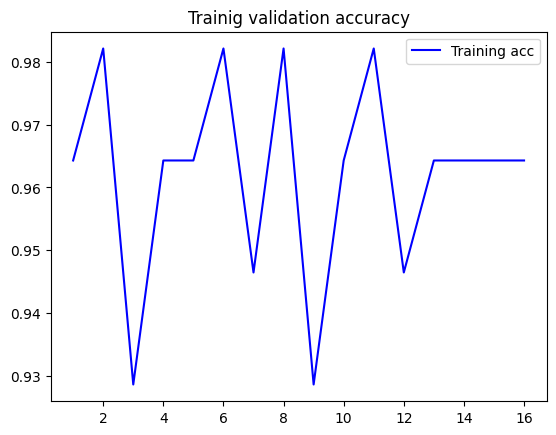

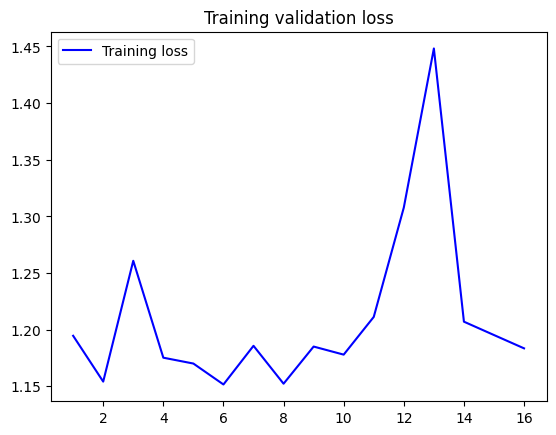

In [49]:
# training accuracy and loss for each epoch

acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label='Training acc')
plt.title('Trainig accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.title('Training loss')
plt.legend()

plt.show()


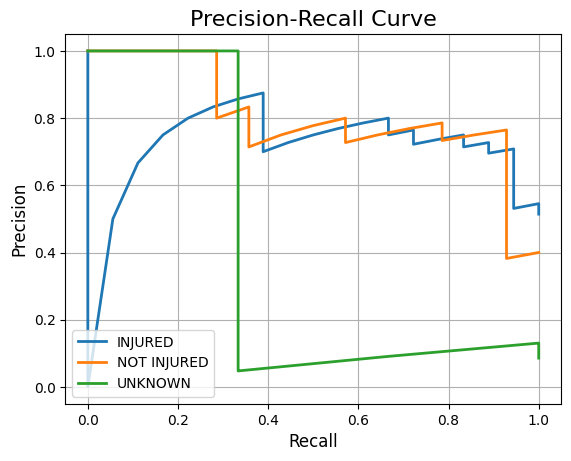

In [50]:
# precision recall curve graph

# binarize y_test (convert to one-hot encoding)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])  # 3 classes

# calculate precision and recall for each class
for i in range(3):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])

    # plot precision-recall curve for each class
    if i == 0:
        plt.plot(recall, precision, lw=2, label='INJURED')
    elif i == 1:
        plt.plot(recall, precision, lw=2, label='NOT INJURED')
    elif i == 2:
        plt.plot(recall, precision, lw=2, label='UNKNOWN')

# Plot details
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=16)
plt.legend(loc='lower left')
plt.grid()
plt.show()